# Oversampling with SMOTE and ADASYN

## Introduction

In [a previous notebook](https://www.kaggle.com/residentmario/undersampling-and-oversampling-imbalanced-data/) I discussed random oversampling and undersampling: what they are, how they work, and why they're useful. The literature on sampling imbalanced datasets extends past these "naive" approaches. The `imbalanced-learn` module in `sklearn` includes a number of more advanced sampling algorithms, and I'll discuss the oversampling-related ones here. Most of these work by generate or subsetting new synthetic points.

## Oversampling with SMOTE

The SMOTE algorithm is one of the first and still the most popular algorithmic approach to generating new dataset samples. The algorithm, introduced and accessibly enough described in a [2002 paper](https://www.jair.org/media/953/live-953-2037-jair.pdf), works by oversampling the underlying dataset with new synthetic points.

The SMOTE algorithm is parameterized with `k_neighbors`  (the number of nearest neighbors it will consider) and the number of new points you wish to create. Each step of the algorithm will:

1. Randomly select a minority point.
2. Randomly select any of its `k_neighbors` nearest neighbors belonging to the same class.
3. Randomly specify a lambda value in the range `[0, 1]`.
4. Generate and place a new point on the vector between the two points, located lambda percent of the way from the original point.

The `imbalanced-learn` documentation includes the following illustration:

![](https://i.imgur.com/yrGAbiR.png)

This is conceptually a very simple algorithm; to quote something a graph theory professor I once had liked to say, you could probably explain how it works to your grandmother.

Let's see what this looks like in practice. Recall the following synthetic sample dataset from the previous notebook:

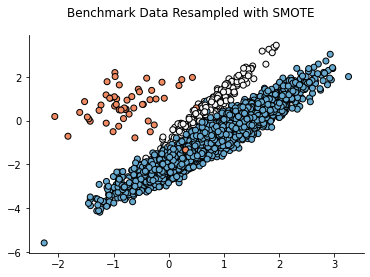

In [1]:
import seaborn as sns
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.01, 0.05, 0.94],
                           class_sep=0.8, random_state=0)

import matplotlib.pyplot as plt
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y]
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
plt.scatter(X[:, 0], X[:, 1], c=colors, **kwarg_params)
sns.despine()
plt.suptitle("Benchmark Data Resampled with SMOTE")
pass

When we apply SMOTE to this we get:

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

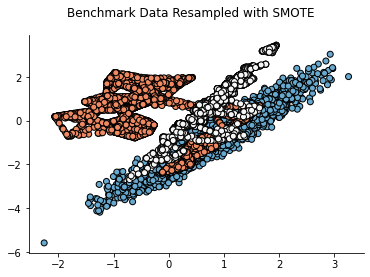

In [2]:
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE().fit_sample(X, y)
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_resampled]
plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=colors, **kwarg_params)
sns.despine()
plt.suptitle("Benchmark Data Resampled with SMOTE")
pass

The weakness of SMOTE is readily apparent from this quick test. Because the algorithm doesn't have any jitter, for minority class sample clouds with few enough points it tends to result in long "data lines". This results in some very funky looking resultant datasets. Somewhat funny-looking results are actually a trademark of these sampling techniques. For a broad class of data it's actually reasonably easy to tell when someone has used SMOTE on it. But remember, we're just building a new dataset sample. Funny looking results are fine, as long as they actually result in improved classifiers when used as input down the line!

SMOTE has also done something here that I am less comfortable with: it's constructed a "bridge" between the main red point cloud and a handful of outlier points located in the blue cluster. We can see that these new points are quite dense if we zoom in on the structure:

(0.0, 1.7)

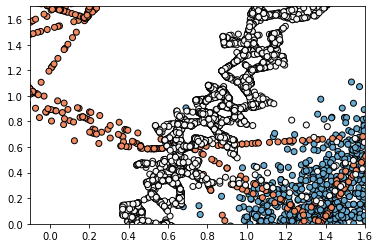

In [3]:
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_resampled]
plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=colors, **kwarg_params)
ax = plt.gca()
ax.set_xlim([-0.1, 1.6])
ax.set_ylim([0, 1.7])

Why does this happen? This surprising new structure shows up prominently because in the "line constructor" nature of SMOTE, a few of the outlier points inside of the blue point cloud will match up sometimes with points in the main body of the class cluster. These will then get interpolated into long spaghetti lines.

This is an artifact of the SMOTE algorithm, and is problematic because it introduces a feature into the dataset, this "point bridge", which doesn't actually exist in the underlying dataset. We can verify this if we increase the incidence rate for this rare class by 10x in the underlying dataset:

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


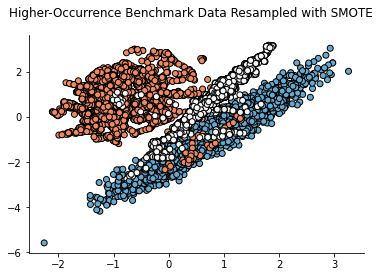

In [4]:
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.10, 0.10, 0.80],
                           class_sep=0.8, random_state=0)
X_resampled, y_resampled = SMOTE().fit_sample(X, y)
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_resampled]
plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=colors, **kwarg_params)
sns.despine()
plt.suptitle("Higher-Occurrence Benchmark Data Resampled with SMOTE")
pass

This tendancy of SMOTE to connect inliers and outliers is the algorithm's primary weakness in practice. It limits the algorithm's applicability to datasets with sufficiently few samples and/or sufficiently sparse point clouds. When applying SMOTE to your own data, make sure to take a good hard look at whether or not it's doing what you expect it to be doing.

`imlearn` includes several adaptations of the naive SMOTE algorithm which attempt to address this weakness in various ways. There are in total four "modes" in `imlearn`. The one demonstrated thus far, the classic SMOTE algorithm, corresponds with `kind='regular'`. The remaining three are adaptations.

`kind='borderline1'` and `kind='borderline2'` are one class of adaptations. These will classify points are being noise (all nearest neighbors are of a different class), in danger (half or more nearest neighbors are a different class), or safe (all nearest neighbors are of the same class). Only points in danger will be sampled in step one of the algorithm. Then, on step two of the algorithm, instead of selecting a point from `n_neighbors` belonging to the same class, `borderline1` will select a point from the five nearest points *not* belonging to the given point's class, while `borderline2` will select a point from the five nearest points of *any* class.

Here is what either algorithm looks like in practice:

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

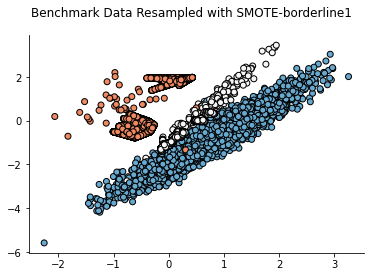

In [5]:
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.01, 0.05, 0.94],
                           class_sep=0.8, random_state=0)

X_resampled, y_resampled = SMOTE(kind='borderline1').fit_sample(X, y)
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_resampled]
plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=colors, **kwarg_params)
sns.despine()
plt.suptitle("Benchmark Data Resampled with SMOTE-borderline1")
pass

The borderline SMOTE algorithms are so named because they will only sample points on the border. Points that are located in a neighborhood of `n_neighbors` points all of their class are left untouched, so e.g. points inside of the class clusters are never sampled. Similarly, the noisy outlier points located inside of the blue cluster are ignored, solving the innerpoint-outerpoint join problem.

However, as the red cluster demonstrates, as a result SMOTE-borderline will tend to focus extremely heavily on the same relatively small number of points. We have replaced extensions to outliers with extensions from borderline points into their neighborhood. New points created in dense, but not totally homogenous neighborhoods which are essentially jittered versions of existing ones: they are displaced just a small amount from their progenitors. But when boundary points are small in number and distant from the rest of their neighborhood, you once again get somewhat odd-looking results: look at those crazy clusters near the decision boundary in the red group!

In this example the clusters overall still look linearly separable, for example, so we would not expect this to significantly effect the performance of e.g. a Linear SVM. But you should always be careful about checking the effect of your transformations net-net.

Now `borderline2`:

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

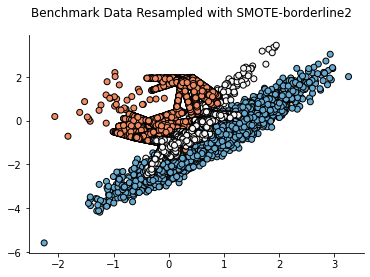

In [6]:
X_resampled, y_resampled = SMOTE(kind='borderline2').fit_sample(X, y)
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_resampled]
plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=colors, **kwarg_params)
sns.despine()
plt.suptitle("Benchmark Data Resampled with SMOTE-borderline2")
pass

Because `borderline2` allows extending to any point class-wise, it will retain a bit of the stringiness of the regular SMOTE, which may make the result less separable. Otherwise the tradeoffs are the same.

The last option is `kind='svm'`. `imlearn` documentation is very vague as to how this works, simply stating that it "uses an SVM classifier to find support vectors and generate samples considering them":

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

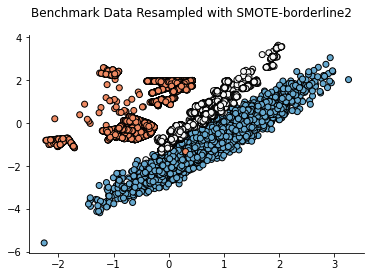

In [7]:
X_resampled, y_resampled = SMOTE(kind='svm').fit_sample(X, y)
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_resampled]
plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=colors, **kwarg_params)
sns.despine()
plt.suptitle("Benchmark Data Resampled with SMOTE-borderline2")
pass

SVM will again focus sampling on points near the boundaries of the clusters.

## Oversampling with ADASYN

The other oversampling technique implemented in `imlearn` is adaptive synthetic sampling, or ADASYN. ADASYN is similar to SMOTE, and derived from it, featuring just one important difference. it will bias the sample space (that is, the likelihood that any particular point will be chosen for duping) towards points which are located not in homogenous neighborhoods. Applied to our sample data, this results in the following:

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


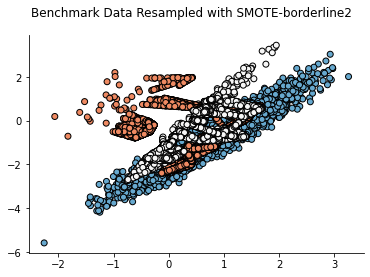

In [8]:
from imblearn.over_sampling import ADASYN

X_resampled, y_resampled = ADASYN().fit_sample(X, y)
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_resampled]
plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=colors, **kwarg_params)
sns.despine()
plt.suptitle("Benchmark Data Resampled with SMOTE-borderline2")
pass

ADASYN uses (1) the `kind='normal'` SMOTE algorithm (2) on point not in homogenous neighborhoods. The result is a kind of hybrid between regular SMOTE and `borderline1` SMOTE. This technique inherits the primary weakness of SMOTE, e.g. its ability to create innerpoint-outerpoint bridges. Whether or not the heavy focus on the outlier points is a good thing or not is application dependent, but overall ADASYN feels like a *very* heavy transformation algorithm, and e.g. one requiring that the underlying point cluster be sufficiently large, as `imblearn` doesn't provide any modifications to this algorithm for modulating its tendency to create them (as it does for SMOTE).